In [24]:
from __future__ import annotations

import ast
import typing as T
import collections.abc as C

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [25]:
def load_dataset(filepath: str) -> pd.DataFrame:
    def parse_values(x: pd.Series) -> pd.Series:
        keys = ast.literal_eval(x.loc["keys"])[0]
        values = (
            float(x) if x != "null" else pd.NA
            for x in ast.literal_eval(x.loc["values"])[0]
        )
        return pd.Series(dict(zip(keys, values)))

    df = pd.read_csv(filepath, parse_dates=[2], index_col=2).sort_index()
    values = df.apply(parse_values, axis=1)
    df = pd.concat([df[["id", "configuration_item_id"]], values], axis=1)
    return df.convert_dtypes()

In [26]:
X_train = load_dataset("data/train999.csv")

X_train

,id,configuration_item_id,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,meteo_t_road,meteo_wind_gusts,meteo_t_air,meteo_air_pressure
ts,,,,,,,,,,,,,,
2024-05-12 09:30:00,0,30928,<NA>,3,4.0,20.0,30.1,<NA>,239,-5.4,26.8,8.0,17.9,746
2024-05-12 10:00:00,1,30928,1.0,3,3.7,19.2,29.0,0.0,297,-5.9,26.2,7.2,17.9,746
2024-05-12 10:30:01,1751,24445,1.0,2,5.0,71.7,20.0,0.0,33,-4.5,24.9,12.3,0.0,745
2024-05-12 11:00:00,2,30928,1.0,3,4.1,20.6,26.0,0.0,266,-5.7,24.5,6.2,17.1,746
2024-05-12 12:00:00,3,30928,1.0,3,2.0,27.8,22.7,0.0,266,-4.0,22.3,3.7,14.3,746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 12:30:00,2766,24445,1.0,3,2.6,29.4,41.8,0.0,351,-15.8,45.9,6.5,0.0,749
2024-06-30 13:30:01,1746,30928,1.0,2,1.0,84.5,29.2,0.0,248,18.0,29.0,1.4,20.7,732
2024-06-30 14:00:01,1747,30928,1.0,3,0.9,87.0,28.3,0.0,275,17.5,28.3,2.1,19.8,732


In [27]:
_, X_train_1 = next(iter(X_train.groupby("configuration_item_id")))

<Axes: xlabel='ts'>

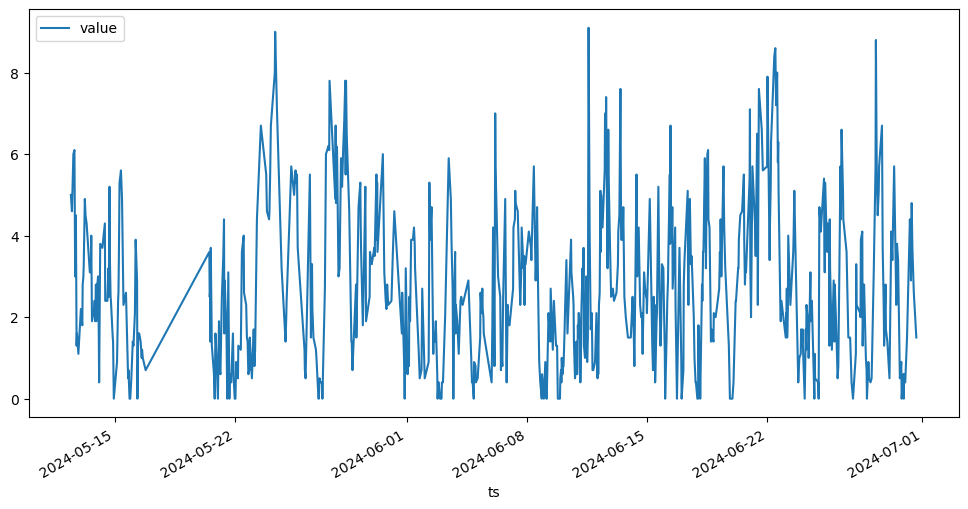

In [28]:
df = pd.DataFrame(X_train_1["meteo_wind_velocity"].rename("value"))
df.plot(figsize=(12, 6))

In [29]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df.values.reshape(-1, 1)) # type: ignore
data = pd.DataFrame(scaled)

model = IsolationForest(contamination="auto")
model.fit(data)

df["anomaly"] = model.predict(data)
df["anomaly"].value_counts()

anomaly
 1    374
-1    350
Name: count, dtype: int64

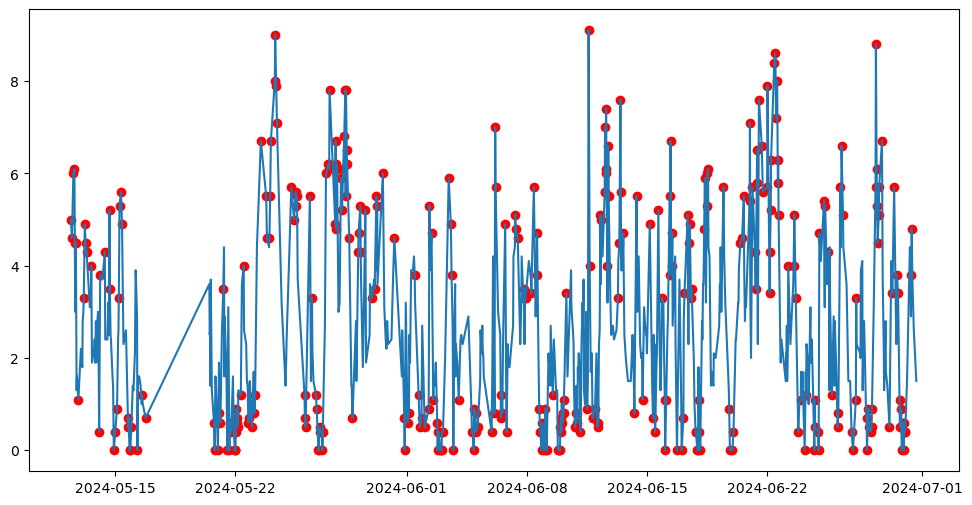

In [30]:
ap = df
# ap = df.loc["2024-06-01":"2024-06-02"]

fig, ax = plt.subplots(figsize=(12, 6))
a = ap.loc[ap["anomaly"] == -1, ["value"]]

ax.plot(ap.index, ap["value"], label="normal")
ax.scatter(a.index, a["value"], color="red", label="Anomaly")

In [31]:
def detect_anomalies(df: pd.DataFrame, *, contamination: str | float = "auto"):
    df = df.copy()
    meteo_cols = [(str(col), series) for col, series in df.items() if str(col).startswith("meteo")]
    
    for col, s in meteo_cols:
        if s.isna().sum() > 0:
            continue
            
        scaler = StandardScaler()
        scaled = scaler.fit_transform(s.values.reshape(-1, 1)) # type: ignore
        data = pd.DataFrame(scaled)
        
        model = IsolationForest(contamination=contamination)
        model.fit(data)

        df[f"anomaly_{col}"] = model.predict(data)
    
    return df

In [32]:
df = detect_anomalies(X_train_1)
df

,id,configuration_item_id,meteo_layer_type,meteo_cloudiness,meteo_wind_velocity,meteo_humidity,meteo_t_underroad,meteo_freezing_point,meteo_wind_direction,meteo_dew_point,...,anomaly_meteo_wind_velocity,anomaly_meteo_humidity,anomaly_meteo_t_underroad,anomaly_meteo_freezing_point,anomaly_meteo_wind_direction,anomaly_meteo_dew_point,anomaly_meteo_t_road,anomaly_meteo_wind_gusts,anomaly_meteo_t_air,anomaly_meteo_air_pressure
ts,,,,,,,,,,,,,,,,,,,,,
2024-05-12 10:30:01,1751,24445,1.0,2,5.0,71.7,20.0,0.0,33,-4.5,...,-1,1,-1,1,1,1,1,-1,-1,1
2024-05-12 12:00:01,1752,24445,1.0,3,4.6,54.0,21.1,0.0,32,-8.2,...,-1,-1,1,1,1,1,1,-1,-1,1
2024-05-12 14:00:02,1753,24445,1.0,3,6.0,46.0,20.6,0.0,35,-10.3,...,-1,1,1,1,-1,1,1,-1,-1,1
2024-05-12 15:30:02,1754,24445,1.0,3,6.1,55.2,19.1,0.0,27,-7.9,...,-1,-1,-1,1,1,1,-1,-1,-1,1
2024-05-12 16:00:01,1755,24445,1.0,3,4.5,54.2,18.3,0.0,27,-8.2,...,-1,-1,-1,1,1,1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30 08:30:01,2762,24445,1.0,3,2.9,33.4,37.2,0.0,351,-14.2,...,-1,-1,1,1,1,-1,-1,1,-1,1
2024-06-30 09:30:01,2764,24445,1.0,3,4.8,31.6,39.8,0.0,352,-14.9,...,-1,1,-1,1,-1,-1,-1,1,-1,1
2024-06-30 10:30:02,2765,24445,1.0,3,3.7,30.0,41.9,0.0,354,-15.5,...,1,-1,-1,1,-1,-1,-1,1,-1,1


In [45]:
# plot anomalies

def plot_anomalies(df: pd.DataFrame):
    anomaly_cols = [x for x in df.columns if x.startswith("anomaly")]
    plot_count = len(anomaly_cols)

    fig, axes = plt.subplots(plot_count, figsize=(12, 6 * plot_count))
    axes = axes.flat
    axes = T.cast(C.Sequence[Axes], axes)

    for anomaly_name, ax in zip(anomaly_cols, axes):
        col = anomaly_name[len("anomaly_"):]
        a = df.loc[df[anomaly_name] == -1, [col]]

        ax.plot(df.index, df[col], label=col)
        ax.scatter(a.index, a[col], color="red", label="anomaly")
        ax.legend(loc="upper left")

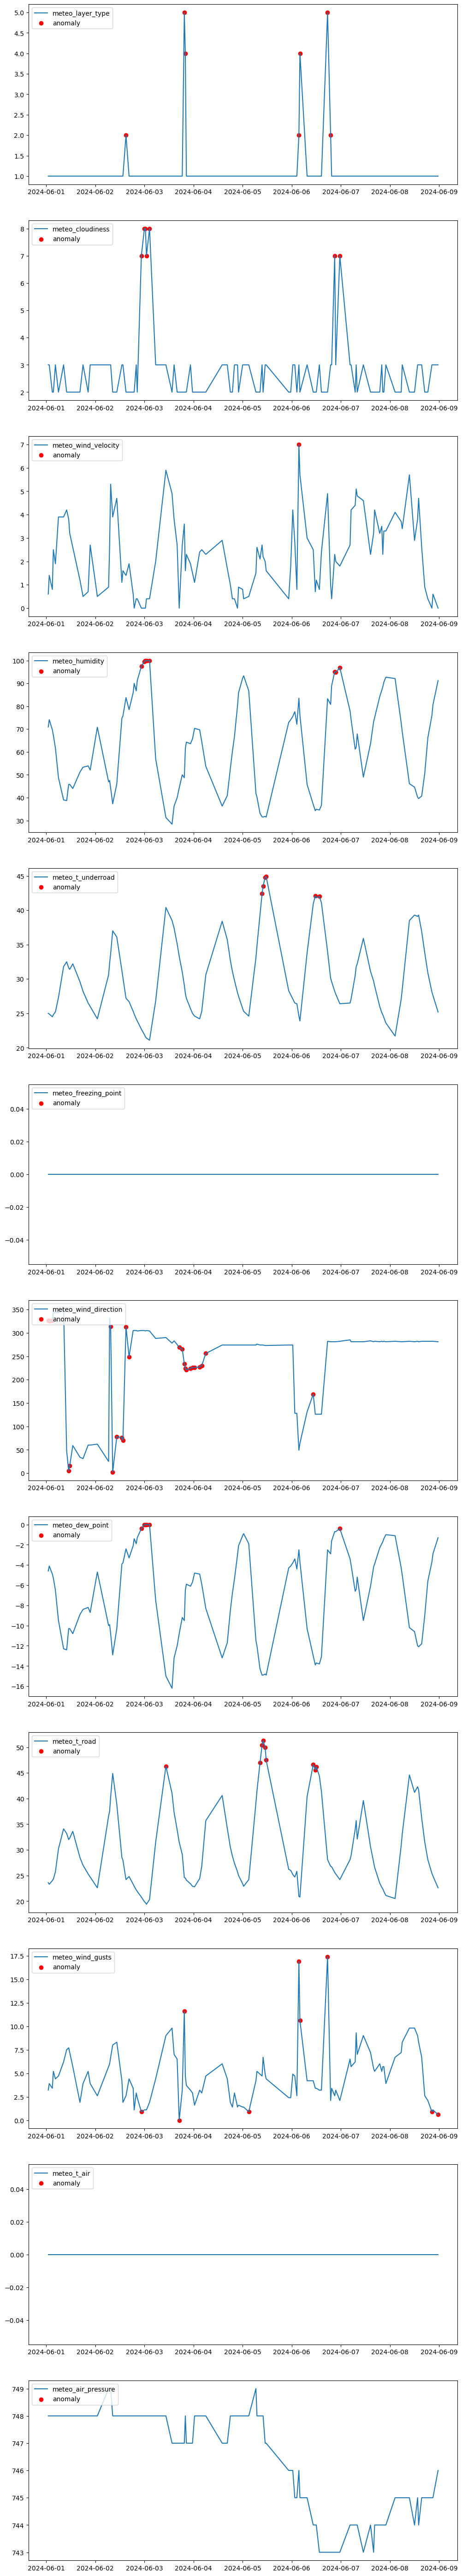

In [46]:
anomalies = detect_anomalies(X_train_1, contamination=0.1)
df = anomalies.loc["2024-06-01":"2024-06-08"]
plot_anomalies(df)

In [21]:
skipped_meteo_cols = [
    c for c in df.columns if c.startswith("meteo") and f"anomaly_{c}" not in df.columns
]

filled_df = df.copy()
for col in skipped_meteo_cols:
    filled_df[f"anomaly_{col}"] = df[col].isna().map({True: -1, False: 1})

skipped_meteo_cols

[]

In [22]:
meteo_cols = [col for col in filled_df.columns if col.startswith("meteo")]
sorted_anomaly_cols = sorted(
    (x for x in df.columns if x.startswith("anomaly")),
    key=lambda a: meteo_cols.index(a[len("anomaly_") :]),
)
sorted_anomaly_cols

['anomaly_meteo_layer_type',
 'anomaly_meteo_cloudiness',
 'anomaly_meteo_wind_velocity',
 'anomaly_meteo_humidity',
 'anomaly_meteo_t_underroad',
 'anomaly_meteo_freezing_point',
 'anomaly_meteo_wind_direction',
 'anomaly_meteo_dew_point',
 'anomaly_meteo_t_road',
 'anomaly_meteo_wind_gusts',
 'anomaly_meteo_t_air',
 'anomaly_meteo_air_pressure']

In [23]:
result = df[["id", *sorted_anomaly_cols]].set_index("id")
result = result.replace({1: 0, -1: 1})
result

,anomaly_meteo_layer_type,anomaly_meteo_cloudiness,anomaly_meteo_wind_velocity,anomaly_meteo_humidity,anomaly_meteo_t_underroad,anomaly_meteo_freezing_point,anomaly_meteo_wind_direction,anomaly_meteo_dew_point,anomaly_meteo_t_road,anomaly_meteo_wind_gusts,anomaly_meteo_t_air,anomaly_meteo_air_pressure
id,,,,,,,,,,,,
2080,0,0,0,0,0,0,1,0,0,0,0,0
2081,0,0,0,0,0,0,1,0,0,0,0,0
2082,0,0,0,0,0,0,1,0,0,0,0,0
2083,0,0,0,0,0,0,0,0,0,0,0,0
2084,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2239,0,0,0,0,0,0,0,0,0,0,0,0
2241,0,0,0,0,0,0,0,0,0,0,0,0
2242,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
result["target"] = result.agg(lambda x: "[%s]" % ", ".join(map(str, x)), axis=1)
result["target"].to_csv("out/targets-train-isolation-1.csv")

In [37]:
def fill_skipped(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    skipped_meteo_cols = [
        c
        for c in df.columns
        if c.startswith("meteo") and f"anomaly_{c}" not in df.columns
    ]
    for col in skipped_meteo_cols:
        df[f"anomaly_{col}"] = df[col].isna().map({True: -1, False: 1})
    return df

def compile_results(df: pd.DataFrame) -> pd.DataFrame:
    meteo_cols = [col for col in df.columns if col.startswith("meteo")]
    sorted_anomaly_cols = sorted(
        (x for x in df.columns if x.startswith("anomaly")),
        key=lambda a: meteo_cols.index(a[len("anomaly_") :]),
    )
    
    result = df[["id", *sorted_anomaly_cols]].set_index("id")
    result = result.replace({1: 0, -1: 1})
    result["target"] = result.agg(lambda x: "[%s]" % ", ".join(map(str, x)), axis=1)

    return result

In [40]:
def run_dataset(dataset: pd.DataFrame):
    results: list[pd.DataFrame] = []
    for station, df in dataset.groupby("configuration_item_id"):
        anomalies = detect_anomalies(df)
        filled = fill_skipped(anomalies)
        results.append(compile_results(filled))
    return pd.concat(results)["target"]

In [41]:
run_dataset(X_train)

id
1751    [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0]
1752    [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0]
1753    [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0]
1754    [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0]
1755    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0]
                        ...                 
1742    [1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
1743    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
1746    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
1747    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
1749    [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
Name: target, Length: 1940, dtype: object

In [47]:
X_test = load_dataset("data/test999.csv")

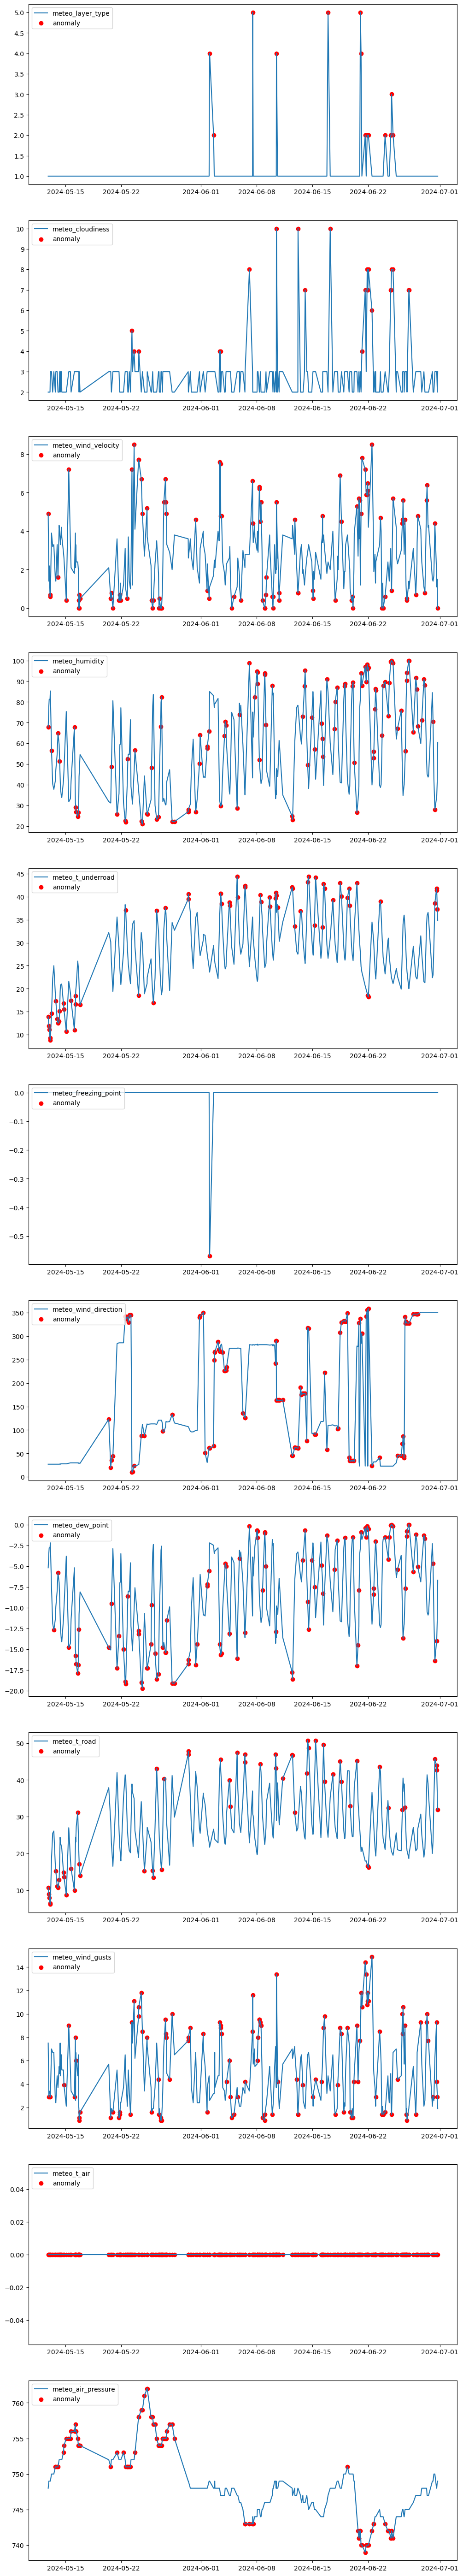

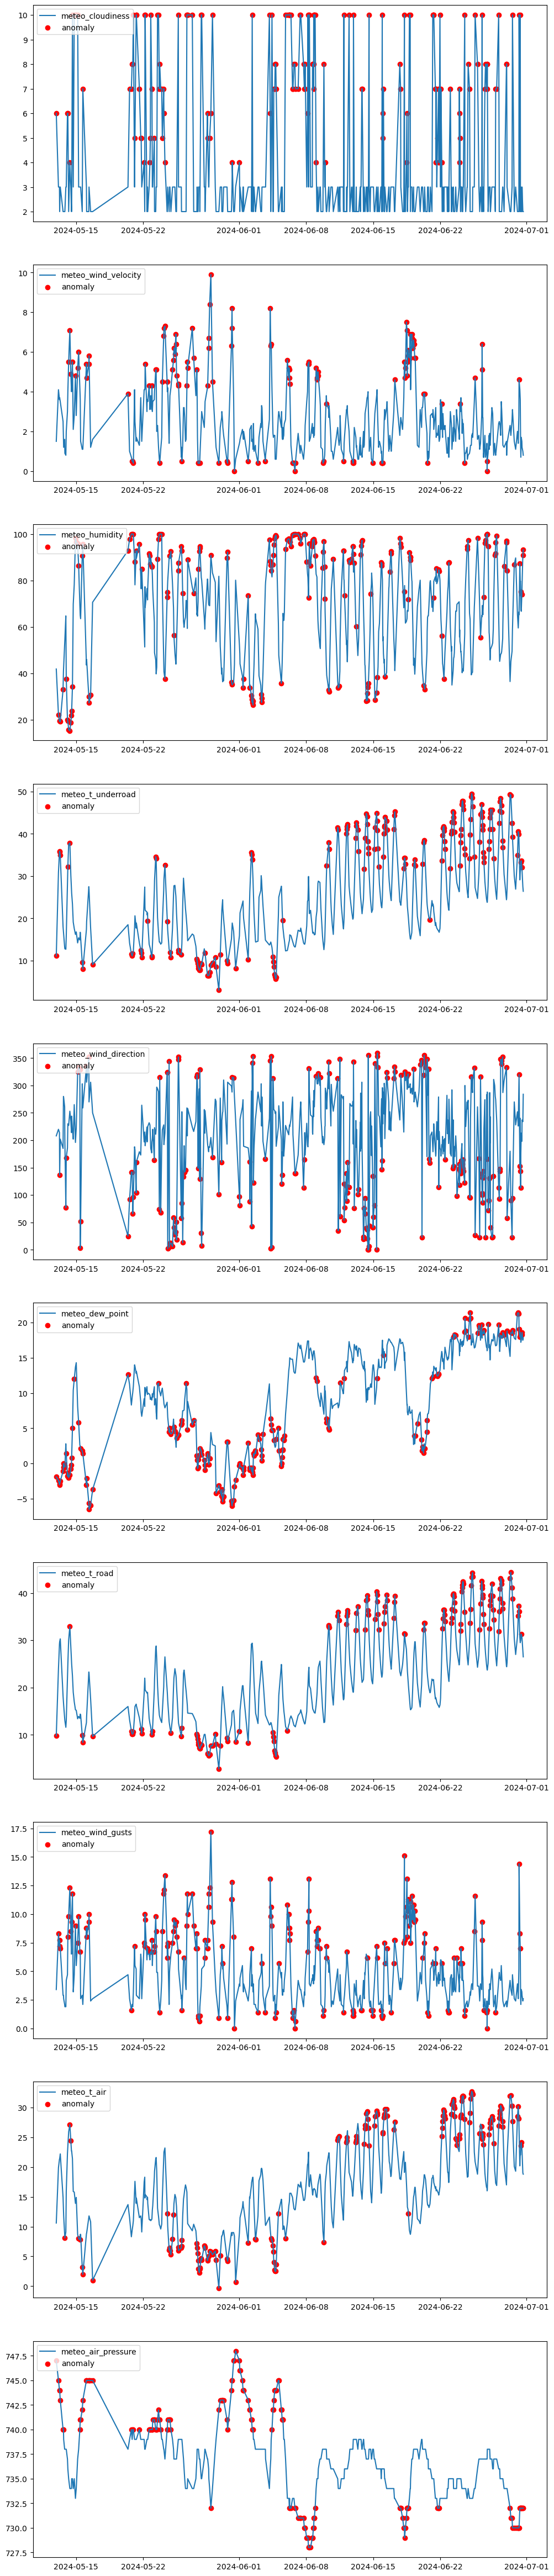

In [48]:
for station, df in X_test.groupby("configuration_item_id"):
    anomalies = detect_anomalies(df)
    plot_anomalies(anomalies)

In [43]:
run_dataset(X_test).to_csv("out/grouped/ewma-test-targets-1.csv")